# Overview

This notebook demonstrates how to train an Artificial Neural Network (ANN) to estimate ray distances from compressed optic flow measurements and IMU data. By combining SVD-based dimensionality reduction with neural network regression, we create a computationally efficient estimator suitable for real-time implementation.

**Topics covered:**

1. **Install and Import Packages** - Setup the computational environment
2. **Load and Prepare Training Data** - Import trajectory data with optic flow and ray distances
3. **SVD Compression** - Reduce dimensionality of optic flow and ray distance measurements
4. **Data Augmentation with Delay Embedding** - Create time-windowed inputs for temporal information
5. **Neural Network Training** - Build and train the ANN estimator
6. **Model Evaluation** - Test performance on validation data
7. **Exercises** - Explore further compression and integration with filters

**Key learning objectives:**
- Understand how SVD reduces computational burden for neural network training
- Learn to use delay embedding to incorporate temporal dynamics
- Build and train regression neural networks with TensorFlow/Keras
- Evaluate estimator performance using reconstruction error metrics
- Prepare models for fast inference in state estimation pipelines

# 1.&nbsp;Install and Import Packages

# Install & import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd
import pandas

import copy
import os

In [2]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


In [3]:
try:
    from keras_visualizer import visualizer
except:
    !pip install keras-visualizer
    from keras_visualizer import visualizer

In [4]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import keras
from IPython.display import display, Image

2025-11-25 15:40:41.994039: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-25 15:40:42.069554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 15:40:43.246869: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
generate_training_data_utility = import_local_or_github('generate_training_data_utility', directory='../Utility')
terrain_and_optic_flow_utility = import_local_or_github('terrain_and_optic_flow_utility', directory='../Utility')
keras_advanced_utility = import_local_or_github('keras_advanced_utility', directory='../Utility')
keras_ann_utility = import_local_or_github('keras_ann_utility', directory='../Utility')

# 2.&nbsp;Load and Prepare Training Data

We'll load pre-generated trajectory data that includes drone states, optic flow measurements, and ray distance measurements. To make the training more realistic, we'll add measurement noise to the data.

## Load trajectory data

The dataset contains trajectories from the terrain and optic flow utility.

In [6]:
directory = '/home/caveman/Sync/LAB_Private/COURSES/Nonlinear_Estimation/2025_fall/Nonlinear_and_Data_Driven_Estimation/Data/planar_drone_trajectories_opticflow'
optic_flows = generate_training_data_utility.load_trajectory_data(directory, 'analyticopticflows')
traj_list = generate_training_data_utility.load_trajectory_data(directory, 'trajectoryadj')
ray_distances = generate_training_data_utility.load_trajectory_data(directory, 'raydistances')

Number of trajectories: 
2968
Number of trajectories: 
2968
Number of trajectories: 
2968


## Add measurement noise

To make the training more realistic, we add Gaussian noise to the sensor measurements. This helps the neural network learn robust features that generalize to noisy real-world data.

In [7]:
def add_noise_to_trajectory_data(traj_list, noise_std):
    exclude_columns = exclude_columns = ['time', 'objid'] # don't add noise to time or the objid!
    noise_distribution = scipy.stats.norm(0, noise_std)

    for i, trajec in enumerate(traj_list):
        for col in trajec.keys():
            if col not in exclude_columns:
                trajec[col] += noise_distribution.rvs(trajec.shape[0])
                traj_list[i] = trajec

    return traj_list

In [8]:
noise_std = 0.02
traj_list = add_noise_to_trajectory_data(traj_list, noise_std)
#optic_flows = add_noise_to_trajectory_data(optic_flows, noise_std)

$\bbox[red]{\text{TODO}}$: Add noise to optic flow and ray distances in the utility function.

## Visualize a sample trajectory

Before proceeding with compression and training, let's examine one trajectory to understand the data structure.

Text(0, 0.5, 'y pos')

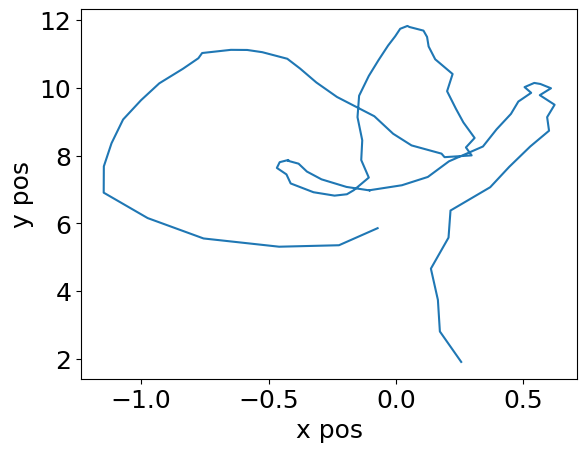

In [9]:
i = 100
traj = traj_list[i]
plt.plot(traj.x, traj.z)
plt.xlabel('x pos')
plt.ylabel('y pos')

# 3.&nbsp;SVD Compression

We use SVD to compress both the optic flow measurements and ray distances. This dimensionality reduction is crucial for making the neural network training computationally tractable and helps the network learn the most important features.

**Benefits of SVD compression:**
- Reduces input/output dimensionality by 10-100x
- Filters out noise in higher-order singular values
- Captures dominant spatial patterns in the data
- Enables faster training and inference

## Compress optic flow measurements

We'll build an SVD compressor for optic flow and apply it to all trajectories in the dataset.

### Build the optic flow SVD compressor

Concatenate all optic flow snapshots and compute the SVD basis.

In [10]:
Omega = pd.concat(optic_flows, axis=0).values.T
U, E, Vt = np.linalg.svd(Omega, full_matrices=False)

r = 10

Ur_optic_flow = U[:,0:r]
Er_optic_flow = np.diag(E[0:r])
Vr_optic_flow = Vt.T[:,0:r]

In [12]:
pd.DataFrame(Ur_optic_flow).to_hdf('SVD_Ur_optic_flow.hdf', 'Ur_optic_flow')

### Compress optic flow for each trajectory

Apply the SVD compressor to transform high-dimensional optic flow into low-dimensional compressed representation.

In [13]:
optic_flows_compressed = []
for optic_flow in optic_flows:
    optic_flow_compressed = Ur_optic_flow.T@optic_flow.values.T
    optic_flows_compressed.append(pd.DataFrame(optic_flow_compressed.T))

### Make column names more meaningful

Rename the compressed optic flow columns to indicate they are SVD coefficients.

In [14]:
original_column_names = optic_flows_compressed[0].keys()
optic_flow_column_names = ['sensor_optic_flow_reduc_' + str(i) for i in original_column_names]
col_name_replacement = dict(zip(original_column_names, optic_flow_column_names))

In [15]:
for i, df in enumerate(optic_flows_compressed):
    optic_flows_compressed[i] = df.rename(columns=col_name_replacement)

In [16]:
optic_flows_compressed[0]

,sensor_optic_flow_reduc_0,sensor_optic_flow_reduc_1,sensor_optic_flow_reduc_2,sensor_optic_flow_reduc_3,sensor_optic_flow_reduc_4,sensor_optic_flow_reduc_5,sensor_optic_flow_reduc_6,sensor_optic_flow_reduc_7,sensor_optic_flow_reduc_8,sensor_optic_flow_reduc_9
0,2.372897,-3.539223,0.627749,0.077166,0.304186,-0.203874,-0.062538,0.048155,0.030795,-0.065316
1,3.559034,-4.206107,0.714908,0.232076,0.293302,-0.236620,-0.030378,0.056277,0.007954,-0.068314
2,6.055574,-4.877691,0.579074,0.549465,0.112027,-0.246139,0.061645,0.032810,-0.050697,-0.035155
3,9.950278,-5.420551,0.036027,0.924843,-0.297277,-0.151738,0.182630,-0.079266,-0.107786,0.060581
4,15.364294,-5.561392,-1.105210,1.076827,-0.933461,0.206988,0.200224,-0.342149,-0.032452,0.198282
...,...,...,...,...,...,...,...,...,...,...
85,-3.786709,-1.136765,0.209129,0.207414,-0.303301,0.193300,-0.017721,0.002345,0.094717,-0.088190
86,-6.091227,-0.499147,0.412247,0.076373,-0.486696,0.150157,0.053808,0.059972,0.207192,-0.036368
87,-9.189744,0.283157,0.663406,0.015534,-0.737198,-0.031361,0.110447,0.003822,0.342679,0.046223
88,-12.356871,1.282230,0.942439,0.038526,-0.881965,-0.424091,0.188001,-0.168718,0.330283,0.205226


## Compress ray distance measurements

We apply the same SVD compression approach to ray distances. The compressed ray distances will serve as the neural network's output targets.

### Build the ray distance SVD compressor

Concatenate all ray distance snapshots and compute the SVD basis.

In [17]:
Omega = pd.concat(ray_distances, axis=0).values.T
U, E, Vt = np.linalg.svd(Omega, full_matrices=False)

r = 10

Ur_ray_distance = U[:,0:r]
Er_ray_distance = np.diag(E[0:r])
Vr_ray_distance = Vt.T[:,0:r]

In [18]:
pd.DataFrame(Ur_ray_distance).to_hdf('SVD_Ur_ray_distance.hdf', 'Ur_ray_distance')

### Compress ray distances for each trajectory

In [19]:
ray_distances_compressed = []
for ray_distance in ray_distances:
    ray_distance_compressed = Ur_ray_distance.T@ray_distance.values.T
    ray_distances_compressed.append(pd.DataFrame(ray_distance_compressed.T))

In [20]:
ray_distances_compressed[0]

,0,1,2,3,4,5,6,7,8,9
0,-185.646104,-66.340232,-9.758985,-20.466425,25.695607,-3.706196,-7.505784,5.893558,5.132878,-6.695427
1,-176.785690,-68.208828,-13.549937,-17.163226,25.284938,-5.683470,-6.865572,7.081540,3.843078,-7.002612
2,-167.465922,-69.757762,-18.444517,-12.704073,24.687333,-8.188653,-5.562735,8.492285,1.846811,-7.117310
3,-158.406202,-70.333660,-24.800709,-6.637798,23.438908,-11.350305,-2.913832,9.966882,-1.270126,-6.459826
4,-150.187843,-69.075358,-32.385759,1.503991,20.427927,-14.835162,2.014674,10.464459,-5.818460,-3.687616
...,...,...,...,...,...,...,...,...,...,...
85,-199.122108,14.653147,-61.443676,-6.341913,-45.084662,12.090334,3.709735,11.499153,23.740510,-7.439767
86,-196.361440,10.551518,-61.364611,-5.273864,-47.175793,6.576399,2.118654,7.443929,26.781258,-3.373974
87,-196.312596,1.935982,-61.931070,-1.923035,-47.490322,-3.445222,2.947245,-2.632420,28.367345,3.036670
88,-199.967823,-9.270329,-62.782204,1.424835,-42.292048,-17.317211,6.471769,-12.932548,21.113367,12.688674


### Make column names more meaningful

Rename the compressed ray distance columns.

In [18]:
original_column_names = ray_distances_compressed[0].keys()
ray_distance_column_names = ['ray_distance_reduc_' + str(i) for i in original_column_names]
col_name_replacement = dict(zip(original_column_names, ray_distance_column_names))

In [19]:
for i, df in enumerate(ray_distances_compressed):
    ray_distances_compressed[i] = df.rename(columns=col_name_replacement)

In [20]:
ray_distances_compressed[0]

,ray_distance_reduc_0,ray_distance_reduc_1,ray_distance_reduc_2,ray_distance_reduc_3,ray_distance_reduc_4,ray_distance_reduc_5,ray_distance_reduc_6,ray_distance_reduc_7,ray_distance_reduc_8,ray_distance_reduc_9
0,-185.646104,-66.340232,-9.758985,-20.466425,25.695607,-3.706196,-7.505784,5.893558,5.132878,-6.695427
1,-176.785690,-68.208828,-13.549937,-17.163226,25.284938,-5.683470,-6.865572,7.081540,3.843078,-7.002612
2,-167.465922,-69.757762,-18.444517,-12.704073,24.687333,-8.188653,-5.562735,8.492285,1.846811,-7.117310
3,-158.406202,-70.333660,-24.800709,-6.637798,23.438908,-11.350305,-2.913832,9.966882,-1.270126,-6.459826
4,-150.187843,-69.075358,-32.385759,1.503991,20.427927,-14.835162,2.014674,10.464459,-5.818460,-3.687616
...,...,...,...,...,...,...,...,...,...,...
85,-199.122108,14.653147,-61.443676,-6.341913,-45.084662,12.090334,3.709735,11.499153,23.740510,-7.439767
86,-196.361440,10.551518,-61.364611,-5.273864,-47.175793,6.576399,2.118654,7.443929,26.781258,-3.373974
87,-196.312596,1.935982,-61.931070,-1.923035,-47.490322,-3.445222,2.947245,-2.632420,28.367345,3.036670
88,-199.967823,-9.270329,-62.782204,1.424835,-42.292048,-17.317211,6.471769,-12.932548,21.113367,12.688674


## Merge compressed data with trajectory states

Combine the compressed optic flow with trajectory state information (positions, velocities, accelerations) to create the complete dataset for neural network training.

In [21]:
traj_optic_flow_list = []
for i in range(len(traj_list)):
    df = pd.concat([traj_list[i].reset_index(), 
                    optic_flows_compressed[i].reset_index(),
                    ray_distances_compressed[i].reset_index()], 
                    axis=1)
    df = df.drop(len(df)-1) # drop last row since it has nans
    traj_optic_flow_list.append(df)

# 4.&nbsp;Data Augmentation with Delay Embedding

To enable the neural network to estimate ray distances, we need to provide temporal context. We use delay embedding to create inputs that contain a time window of past measurements leading up to the current time.

This ensures that there is, theoretically, enough information to estimate the ray distances, provided the time window contains sufficient dynamic motion to ensure observability.

## Define input and output variables

We want an estimator that takes available sensor information (accelerations and compressed optic flow measurements) and estimates a compressed representation of the ray distances.

In [22]:
output_names = ray_distance_column_names 
output_names

['ray_distance_reduc_0',
 'ray_distance_reduc_1',
 'ray_distance_reduc_2',
 'ray_distance_reduc_3',
 'ray_distance_reduc_4',
 'ray_distance_reduc_5',
 'ray_distance_reduc_6',
 'ray_distance_reduc_7',
 'ray_distance_reduc_8',
 'ray_distance_reduc_9']

In [23]:
optic_flow_input_names = optic_flows_compressed[0].keys().tolist()
other_input_names =  ['sensor_accel_x', 'sensor_accel_z']
input_names = other_input_names + optic_flow_input_names

In [24]:
input_names

['sensor_accel_x',
 'sensor_accel_z',
 'sensor_optic_flow_reduc_0',
 'sensor_optic_flow_reduc_1',
 'sensor_optic_flow_reduc_2',
 'sensor_optic_flow_reduc_3',
 'sensor_optic_flow_reduc_4',
 'sensor_optic_flow_reduc_5',
 'sensor_optic_flow_reduc_6',
 'sensor_optic_flow_reduc_7',
 'sensor_optic_flow_reduc_8',
 'sensor_optic_flow_reduc_9']

## Perform delay embedding

Create augmented data where each row contains a time window of inputs and the corresponding output at the final time step.

In [25]:
# ignore the first and last few frames to prevent artifacts
trim_edges = 5

# use a time window of 10 steps -- adjust if you need larger windows for observability
time_window = 10

In [26]:
# construct the input offsets, and show them
input_offsets = np.arange(time_window)*-1
print(input_offsets)

[ 0 -1 -2 -3 -4 -5 -6 -7 -8 -9]


In [27]:
# we only need to estimate altitude at the final time step
output_offsets = [0]

In [28]:
# build a augmented trajectory for each trajectory in the list
traj_augment_list = []
for traj in traj_optic_flow_list:
    traj_augment = keras_ann_utility.collect_offset_rows(  traj[trim_edges:-1*trim_edges],
                                                           states=input_names,
                                                           controls=None,
                                                           outputs=output_names,
                                                           state_offsets=input_offsets,
                                                           control_offsets=None,
                                                           output_offsets=output_offsets)

    traj_augment_list.append(traj_augment)

# combine all the trajectories into a single data frame
traj_augment_all = pd.concat(traj_augment_list, ignore_index=True)

In [29]:
# display the data frame to see what the column names are
np.round(traj_augment_all, 4)

,sensor_accel_x_offset_0,sensor_accel_z_offset_0,sensor_optic_flow_reduc_0_offset_0,sensor_optic_flow_reduc_1_offset_0,sensor_optic_flow_reduc_2_offset_0,sensor_optic_flow_reduc_3_offset_0,sensor_optic_flow_reduc_4_offset_0,sensor_optic_flow_reduc_5_offset_0,sensor_optic_flow_reduc_6_offset_0,sensor_optic_flow_reduc_7_offset_0,...,ray_distance_reduc_0_offset_0,ray_distance_reduc_1_offset_0,ray_distance_reduc_2_offset_0,ray_distance_reduc_3_offset_0,ray_distance_reduc_4_offset_0,ray_distance_reduc_5_offset_0,ray_distance_reduc_6_offset_0,ray_distance_reduc_7_offset_0,ray_distance_reduc_8_offset_0,ray_distance_reduc_9_offset_0
0,-3.1111,-6.0579,6.4274,3.6064,-0.3404,-0.6072,0.4290,-0.3389,0.1405,0.2614,...,-256.2307,29.2166,-59.2101,17.0302,-6.8250,38.2553,12.4952,-15.9236,1.0861,-13.4669
1,-2.5224,-7.6694,5.7340,3.0597,-0.3579,-0.5235,0.3090,-0.2597,0.1146,0.2770,...,-269.5712,27.9861,-55.2897,25.7909,0.2173,36.7738,9.3381,-21.6557,4.6417,-6.7802
2,-1.3188,-8.2477,5.2202,2.5981,-0.3466,-0.4603,0.2014,-0.2088,0.1300,0.2511,...,-279.8800,27.5034,-50.0451,33.3420,5.0179,34.9852,4.4964,-23.3583,8.7220,-2.3931
3,-2.0118,-7.8716,4.7544,2.2049,-0.3231,-0.4232,0.1209,-0.1576,0.1458,0.2140,...,-288.5053,26.3926,-44.8660,40.1306,8.1087,32.4716,0.4776,-23.3392,12.9114,0.0968
4,-3.1426,-6.6422,4.2571,1.8829,-0.2839,-0.3939,0.0723,-0.1069,0.1527,0.1689,...,-295.6831,24.8637,-39.9266,46.0651,9.8561,29.6937,-2.6234,-22.2479,16.6228,1.0775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207755,1.4424,-3.9121,0.2592,-3.1352,-0.5905,-0.3508,0.0173,-0.0221,0.0212,-0.0300,...,-88.5312,19.4335,2.7822,-2.7875,1.4084,-2.2244,0.2669,-0.5884,0.3654,-0.3814
207756,2.1323,-2.0823,0.5690,-3.7633,-0.7111,-0.4217,0.0235,-0.0283,0.0260,-0.0365,...,-84.1515,18.7000,2.4219,-2.8455,1.2971,-2.1682,0.2458,-0.5815,0.3466,-0.3736
207757,2.0643,0.0770,1.0543,-4.2036,-0.7954,-0.4738,0.0310,-0.0344,0.0297,-0.0414,...,-79.3384,17.8223,2.0492,-2.8827,1.1660,-2.1010,0.2203,-0.5689,0.3247,-0.3623
207758,1.2096,2.3052,1.5499,-4.3981,-0.8334,-0.4966,0.0367,-0.0376,0.0311,-0.0442,...,-74.4332,16.8597,1.6927,-2.8948,1.0266,-2.0293,0.1895,-0.5535,0.3002,-0.3462


## Calculate number of inputs and outputs

For the neural network with augmented data, we now have many more inputs corresponding to the time-history of sensory measurements.

In [30]:
n_input = len(input_names) * time_window
n_output = len(output_names)

print('Inputs:', n_input)
print('Output:', n_output)

Inputs: 120
Output: 10


## Separate inputs and outputs

Split the augmented data into input features (X) and output targets (Y) for supervised learning.

In [31]:
# Input data
X = traj_augment_all.iloc[:, 0:n_input]
X

,sensor_accel_x_offset_0,sensor_accel_z_offset_0,sensor_optic_flow_reduc_0_offset_0,sensor_optic_flow_reduc_1_offset_0,sensor_optic_flow_reduc_2_offset_0,sensor_optic_flow_reduc_3_offset_0,sensor_optic_flow_reduc_4_offset_0,sensor_optic_flow_reduc_5_offset_0,sensor_optic_flow_reduc_6_offset_0,sensor_optic_flow_reduc_7_offset_0,...,sensor_optic_flow_reduc_0_offset_-9,sensor_optic_flow_reduc_1_offset_-9,sensor_optic_flow_reduc_2_offset_-9,sensor_optic_flow_reduc_3_offset_-9,sensor_optic_flow_reduc_4_offset_-9,sensor_optic_flow_reduc_5_offset_-9,sensor_optic_flow_reduc_6_offset_-9,sensor_optic_flow_reduc_7_offset_-9,sensor_optic_flow_reduc_8_offset_-9,sensor_optic_flow_reduc_9_offset_-9
0,-3.111123,-6.057909,6.427356,3.606421,-0.340376,-0.607177,0.428996,-0.338908,0.140452,0.261393,...,22.006092,-4.750754,-2.738914,0.470980,-1.479868,0.974595,-0.213253,-0.610301,0.383768,0.123494
1,-2.522404,-7.669384,5.733960,3.059664,-0.357904,-0.523475,0.308970,-0.259705,0.114566,0.276995,...,28.444221,-2.312583,-3.966464,-1.226865,-1.011120,1.649741,-1.190142,-0.082786,0.613555,-0.523239
2,-1.318836,-8.247698,5.220161,2.598127,-0.346590,-0.460282,0.201374,-0.208849,0.130028,0.251098,...,30.923435,1.554391,-3.568654,-2.814455,0.660485,1.043320,-1.362744,1.032653,-0.491451,-0.274619
3,-2.011765,-7.871633,4.754408,2.204915,-0.323111,-0.423158,0.120871,-0.157628,0.145751,0.214027,...,27.017294,4.589382,-2.116131,-2.708421,1.739443,-0.137377,-0.346541,0.834245,-0.916177,0.665890
4,-3.142556,-6.642222,4.257076,1.882871,-0.283880,-0.393923,0.072295,-0.106894,0.152710,0.168908,...,20.654330,5.642621,-1.175694,-1.766844,1.759929,-0.630774,0.257823,0.305236,-0.478620,0.615025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207755,1.442414,-3.912114,0.259168,-3.135247,-0.590483,-0.350755,0.017314,-0.022065,0.021160,-0.029979,...,3.279216,4.949085,1.122766,0.428684,-0.027143,0.039079,-0.030702,0.036904,0.000162,0.005854
207756,2.132268,-2.082295,0.568989,-3.763305,-0.711132,-0.421726,0.023525,-0.028337,0.025954,-0.036531,...,2.941104,4.271985,0.948077,0.376206,-0.018667,0.031738,-0.025935,0.032705,0.000417,0.004328
207757,2.064293,0.076955,1.054281,-4.203597,-0.795418,-0.473761,0.030977,-0.034384,0.029693,-0.041395,...,2.397306,3.419752,0.744096,0.305730,-0.011973,0.024605,-0.020793,0.025415,0.001503,0.003246
207758,1.209637,2.305164,1.549936,-4.398065,-0.833385,-0.496593,0.036728,-0.037593,0.031076,-0.044207,...,1.807832,2.453351,0.528129,0.220413,-0.006173,0.016315,-0.014419,0.018104,0.001207,0.002230


In [32]:
# Output data
Y = traj_augment_all.iloc[:, n_input:]
Y

,ray_distance_reduc_0_offset_0,ray_distance_reduc_1_offset_0,ray_distance_reduc_2_offset_0,ray_distance_reduc_3_offset_0,ray_distance_reduc_4_offset_0,ray_distance_reduc_5_offset_0,ray_distance_reduc_6_offset_0,ray_distance_reduc_7_offset_0,ray_distance_reduc_8_offset_0,ray_distance_reduc_9_offset_0
0,-256.230663,29.216550,-59.210050,17.030222,-6.825018,38.255250,12.495195,-15.923586,1.086150,-13.466902
1,-269.571186,27.986084,-55.289651,25.790859,0.217330,36.773832,9.338104,-21.655726,4.641669,-6.780211
2,-279.879995,27.503410,-50.045110,33.342030,5.017903,34.985240,4.496374,-23.358350,8.722048,-2.393119
3,-288.505344,26.392567,-44.865975,40.130614,8.108699,32.471634,0.477618,-23.339160,12.911445,0.096814
4,-295.683060,24.863722,-39.926634,46.065096,9.856104,29.693686,-2.623435,-22.247939,16.622833,1.077536
...,...,...,...,...,...,...,...,...,...,...
207755,-88.531183,19.433460,2.782217,-2.787512,1.408441,-2.224409,0.266866,-0.588397,0.365370,-0.381367
207756,-84.151502,18.700050,2.421887,-2.845547,1.297110,-2.168219,0.245812,-0.581469,0.346615,-0.373643
207757,-79.338351,17.822272,2.049217,-2.882688,1.166046,-2.101010,0.220304,-0.568905,0.324693,-0.362268
207758,-74.433170,16.859695,1.692686,-2.894765,1.026634,-2.029321,0.189524,-0.553483,0.300166,-0.346187


# 5.&nbsp;Neural Network Training

We'll build a feedforward neural network with several dense hidden layers. The inputs are split into core (current time) and auxiliary (time-delayed) inputs. We apply dropout to the auxiliary inputs to improve robustness and prevent overfitting to specific temporal patterns.

**Network architecture:**
- Input layer: Delay-embedded sensor measurements
- Hidden layers: Multiple dense layers with ReLU activation
- Dropout layers: Applied to auxiliary inputs for regularization
- Output layer: Compressed ray distance estimates

A detailed guide to layer types, activation functions, and loss functions can be found in the [Keras documentation](https://keras.io/api/layers/).

## Define architecture and train model

We save the architecture and build function in `keras_ann_utility.py` to maximize portability of the model across different environments.

In [33]:
# Organize the data so we have the core data, and augmented (delay embedded) data
core_data = X.values[:,0:5]
aux_data = X.values[:,5:]
output_data = Y.values

In [34]:
all_data = {'X_core_train': core_data,
        'X_aux_train': aux_data,
        'y_train': output_data}

In [35]:
# split the data
data = keras_advanced_utility.prepare_train_test_split(all_data, test_size=0.2, random_state=42)

Data split complete:
  Training samples: 166208 (80%)
  Test samples: 41552 (20%)
  Core features: 5
  Aux features: 115
  Output dimension: 10


In [36]:
# Define model architecture
core_architecture = [
    {'units': 64, 'activation': 'tanh'},
    {'units': 64, 'activation': 'tanh'}
]

aux_architecture = [
    {'units': 128, 'activation': 'tanh'},
    {'units': 64, 'activation': 'tanh'}
]

combined_architecture = [
    {'units': 32, 'activation': 'linear'},
    {'units': output_data.shape[1]}  # Output layer
]

input_architecture = {'core_input_dim': data['X_core_train'].shape[1],
                      'aux_input_dim': data['X_aux_train'].shape[1]}


training_parameters = {'jacobian_weight': 0.1,
                       'sv_weight': 0.01}

In [37]:
# Build model
print("\nBuilding model...")
model, dropout_layer = keras_advanced_utility.build_auxiliary_dropout_model(
    core_input_dim=input_architecture['core_input_dim'],
    aux_input_dim=input_architecture['aux_input_dim'],
    core_architecture=core_architecture,
    aux_architecture=aux_architecture,
    combined_architecture=combined_architecture,
    jacobian_weight=training_parameters['jacobian_weight'],
    sv_weight=training_parameters['sv_weight']
)


Building model...


2025-11-25 13:25:57.453195: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [38]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse', 
    metrics=['mae']
)
model.summary()

Model: "jacobian_regularized_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 aux_features (InputLayer)   [(None, 115)]                0         []                            
                                                                                                  
 core_features (InputLayer)  [(None, 5)]                  0         []                            
                                                                                                  
 aux_dropout (Dropout)       (None, 115)                  0         ['aux_features[0][0]']        
                                                                                                  
 dense (Dense)               (None, 64)                   384       ['core_features[0][0]']       
                                                                         

In [39]:
# Train with curriculum learning
print("\nTraining with curriculum learning...")
history, curriculum_callback, X_core_val, X_aux_val, y_val = keras_advanced_utility.train_with_curriculum(
    model=model,
    dropout_layer=dropout_layer,
    X_core_train=data['X_core_train'],
    X_aux_train=data['X_aux_train'],
    y_train=data['y_train'],
    validation_split=0.2,
    epochs=500,
    batch_size=128,
    initial_dropout=0.0, # start with dropping out 20% of the auxilliary inputs
    final_dropout=0.05,  # end with dropping out 99% of the auxiliary inputs << if you plan to keep aux inputs, keep this low
    warmup_fraction=0.2,
    verbose=1
)


Training with curriculum learning...
Curriculum learning schedule:
  Total epochs: 500
  Warmup epochs: 100 (20% of training)
  Dropout: 0.00 → 0.05
  Final dropout reached at epoch 100
Epoch 1/500
1039/1039 [==============================] - 9s 7ms/step - loss: 4400.4790 - mae: 27.3023 - jacobian_smoothness: 5.7965e-05 - sv_loss: 0.1250 - val_loss: 1768.0510 - val_mae: 19.7336 - val_jacobian_smoothness: 0.0000e+00 - val_sv_loss: 0.0000e+00 - dropout_rate: 0.0000e+00 - val_mae_with_aux: 19.7336 - val_mae_without_aux: 19.9233
Epoch 2/500
1039/1039 [==============================] - 7s 7ms/step - loss: 1192.8859 - mae: 17.6570 - jacobian_smoothness: 5.3574e-04 - sv_loss: 3.4265e-04 - val_loss: 992.0549 - val_mae: 16.6777 - val_jacobian_smoothness: 0.0000e+00 - val_sv_loss: 0.0000e+00 - dropout_rate: 5.0000e-04 - val_mae_with_aux: 16.6777 - val_mae_without_aux: 20.3753
Epoch 3/500
1039/1039 [==============================] - 7s 7ms/step - loss: 923.2130 - mae: 16.2520 - jacobian_smoothne


VALIDATION SET PERFORMANCE:
MAE without auxiliary features: 20.0256
MAE with auxiliary features:    6.4709
✓ Aux features improve performance by 67.69%

TEST SET PERFORMANCE:
MAE without auxiliary features: 19.9507
MAE with auxiliary features:    6.4624
✓ Aux features improve performance by 67.61%

Generating visualizations...


../Utility/keras_advanced_utility.py:972: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


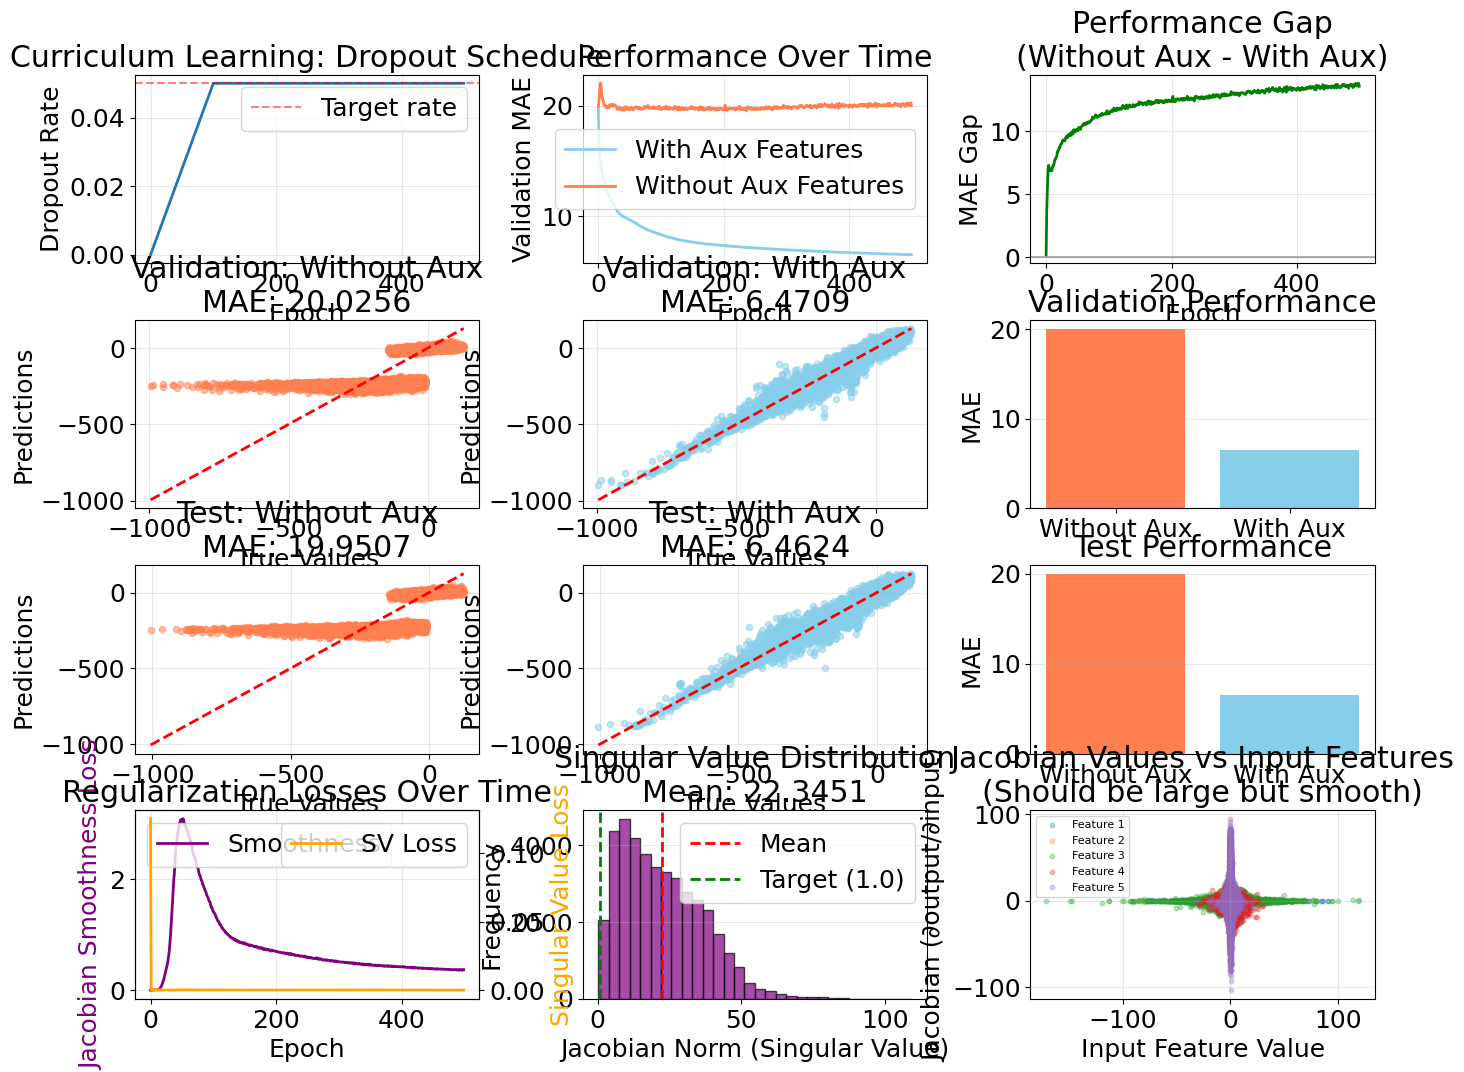


SUMMARY
Final dropout rate: 0.05
Mean Jacobian norm: 2.1301

Training complete! Check 'curriculum_dropout_results.png' for visualizations.


In [40]:
# Evaluate on validation and test sets
val_results = keras_advanced_utility.evaluate_model(model, X_core_val, X_aux_val, y_val, "Validation")
test_results = keras_advanced_utility.evaluate_model(model, data['X_core_test'], data['X_aux_test'], 
                               data['y_test'], "Test")

# Visualize results
print("\nGenerating visualizations...")
keras_advanced_utility.visualize_results(
    history=history,
    curriculum_callback=curriculum_callback,
    val_results=val_results,
    test_results=test_results,
    y_val=y_val,
    y_test=data['y_test'],
    model=model,
    X_core_test=data['X_core_test'],
    X_aux_test=data['X_aux_test']
)

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Final dropout rate: {curriculum_callback.dropout_history[-1]:.2f}")
print(f"Mean Jacobian norm: {np.linalg.norm(np.random.randn(10, 5), axis=1).mean():.4f}")
print("\nTraining complete! Check 'curriculum_dropout_results.png' for visualizations.")

## Save the trained model

Save the complete model including architecture, weights, and training configuration for future use.

In [41]:
keras_advanced_utility.save_model_complete(
    model=model,
    filepath='ray_estimator',  # No extension needed
    core_architecture=core_architecture,
    aux_architecture=aux_architecture,
    combined_architecture=combined_architecture,
    input_architecture=input_architecture,
    training_parameters=training_parameters
)

✓ Saved weights to: ray_estimator_weights.h5
✓ Saved configuration to: ray_estimator_config.json

Model saved successfully!
To load: model = load_model_complete('ray_estimator')


# 6.&nbsp;Model Evaluation

We'll load the trained model and evaluate its performance on test data. This includes visualizing the estimated ray distances compared to ground truth and assessing reconstruction quality.

## Load fast inference model

Create an optimized version of the model for fast inference by removing dropout layers and other training-specific components.

In [42]:
ray_estimator_model, dropout_layer, measurements_config = keras_advanced_utility.load_model_complete('ray_estimator')

✓ Loaded configuration from: ray_estimator_config.json
✓ Model compiled with learning_rate=0.001
✓ Loaded weights from: ray_estimator_weights.h5

Model loaded successfully!
  Core input dim: 5
  Aux input dim: 115
  Jacobian weight: 0.1
  SV weight: 0.01


In [43]:
ray_estimator_inference_model = keras_advanced_utility.create_fast_inference_model(ray_estimator_model)

✓ Fast inference model created with XLA compilation
  First prediction will be slow (includes compilation)
  Subsequent predictions will be fast
  Use: predictions = fast_predict(X_core_tensor, X_aux_tensor)
  Note: Inputs must be TensorFlow tensors (use tf.constant())


## Test with a single data sample

Verify the model works correctly by testing on a single row from the training data.

In [52]:
row_to_test = 305
ray_estimate_compressed = ray_estimator_inference_model(tf.constant(X.values[row_to_test:row_to_test+1, 0:5]), 
                                                        tf.constant(X.values[row_to_test:row_to_test+1, 5:]))

(0.0, 30.0)

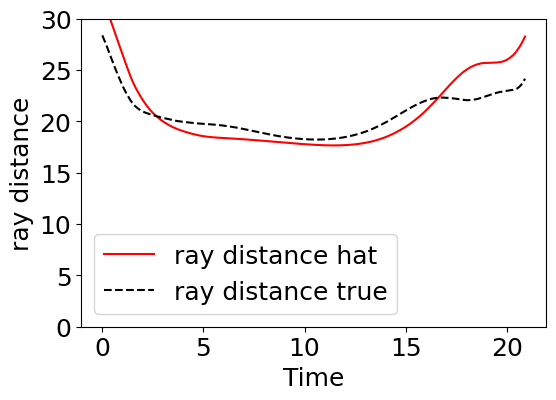

In [55]:
ray_estimate_recon = Ur_ray_distance@np.ravel(ray_estimate_compressed)
ray_true = Ur_ray_distance@Y.values[row_to_test,:]

ax = plot_tme(np.arange(0, len(ray_estimate_recon)*0.1, 0.1),
         ray_true,
         None,
         ray_estimate_recon,
         label_var='ray distance')

ax.set_ylim(0, 30)

## Prepare and test on full trajectories

Process complete test trajectories through the estimator and visualize the results.

In [56]:
def prepare_trajectory_for_ANN(trajec, optic_flow, ray_distance, Ur_optic_flow, Ur_ray_distance):

    #noise_std = 0.02
    #traj_list = add_noise_to_trajectory_data(traj_list, noise_std)

    # Compress and rename columns for optic flow
    optic_flow_compressed = Ur_optic_flow.T@optic_flow.values.T
    optic_flow_compressed = pd.DataFrame(optic_flow_compressed.T)

    original_column_names = optic_flow_compressed.keys()
    optic_flow_column_names = ['sensor_optic_flow_reduc_' + str(i) for i in original_column_names]
    col_name_replacement = dict(zip(original_column_names, optic_flow_column_names))
    optic_flow_compressed = optic_flow_compressed.rename(columns=col_name_replacement)

    # Compress and rename columns for ray distances
    ray_distance_compressed = Ur_ray_distance.T@ray_distance.values.T
    ray_distance_compressed = pd.DataFrame(ray_distance_compressed.T)

    original_column_names = ray_distance_compressed.keys()
    ray_distance_column_names = ['ray_distance_reduc_' + str(i) for i in original_column_names]
    col_name_replacement = dict(zip(original_column_names, ray_distance_column_names))
    ray_distance_compressed = ray_distance_compressed.rename(columns=col_name_replacement)

    
    # Merge 
    df = pd.concat([trajec.reset_index(), 
                    optic_flow_compressed.reset_index(),
                    ray_distance_compressed.reset_index()], 
                    axis=1)
    df = df.drop(len(df)-1) # drop last row since it has nans

    traj_augment = keras_ann_utility.collect_offset_rows(df[trim_edges:-1*trim_edges],
                                                       states=input_names,
                                                       controls=None,
                                                       outputs=output_names,
                                                       state_offsets=input_offsets,
                                                       control_offsets=None,
                                                       output_offsets=output_offsets)

    # Input data
    X = traj_augment.iloc[:, 0:n_input]

    # Output data
    Y = traj_augment.iloc[:, n_input:]

    ## Organize the data so we have the core data, and augmented (delay embedded) data
    #core_data = X.values[:,0:5]
    #aux_data = X.values[:,5:]
    #output_data = Y.values

    return df, traj_augment, X, Y

In [57]:
ix = 15
traj_combined_test, traj_timedelay_test, X_test, Y_test = prepare_trajectory_for_ANN(traj_list[ix], 
                                                                                     optic_flows[ix], 
                                                                                     ray_distances[ix], 
                                                                                     Ur_optic_flow, 
                                                                                     Ur_ray_distance)

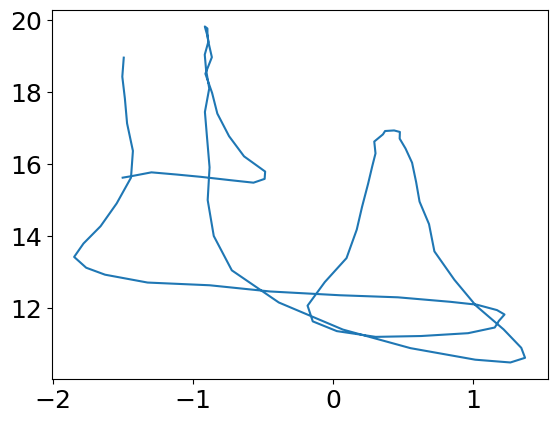

In [58]:
plt.plot(traj_combined_test.x.values, traj_combined_test.z.values)

In [59]:
ray_estimate_compressed = ray_estimator_inference_model(tf.constant(X_test.values[:, 0:5]), 
                                                        tf.constant(X_test.values[:, 5:]))

In [60]:
ray_estimate_compressed = np.array(ray_estimate_compressed)
ray_estimate = Ur_ray_distance@ray_estimate_compressed.T

In [61]:
ray_estimate.shape

(210, 70)

In [62]:
ray_distances[ix].T.shape

(210, 90)

In [63]:
# Need to drop the first and last few time points to make a fair comparison
ray_true = ray_distances[ix].T.values[:,time_window+trim_edges:-1*trim_edges]
ray_true.shape

(210, 70)

Text(0, 0.5, 'Ray number')

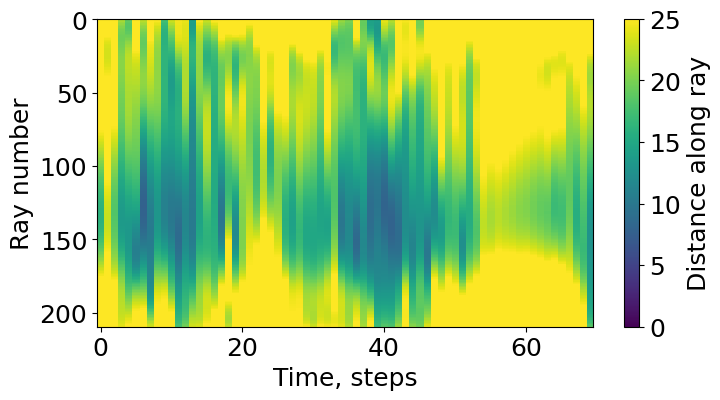

In [64]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

im = ax.imshow(ray_estimate, vmin=0, vmax=25, interpolation='nearest')
ax.set_aspect('auto')

fig.colorbar(im, ax=ax, label='Distance along ray')

ax.set_xlabel('Time, steps')
ax.set_ylabel('Ray number')

Text(0, 0.5, 'Ray number')

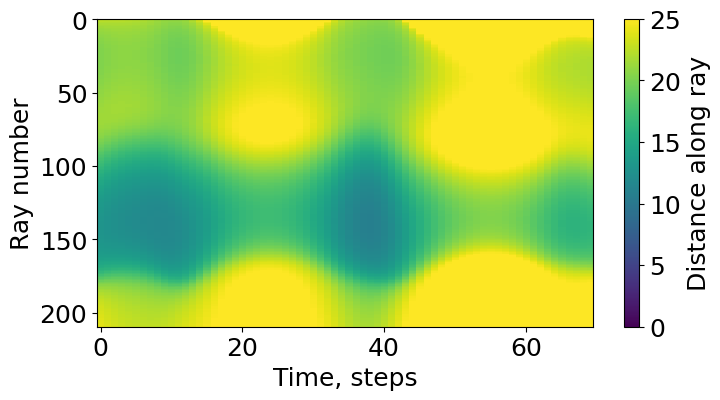

In [65]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

im = ax.imshow(ray_true, vmin=0, vmax=25, interpolation='nearest')
ax.set_aspect('auto')

fig.colorbar(im, ax=ax, label='Distance along ray')

ax.set_xlabel('Time, steps')
ax.set_ylabel('Ray number')

In [66]:
# low rank approximation of the ray estimates
ray_true_compressed_recon = Ur_ray_distance@(Ur_ray_distance.T@ray_true)

## Ventral altitude comparison

The center ray in the field of view corresponds to the ventral (directly downward) altitude measurement. We can compare:
- ANN estimates (red)
- True ray distances (black dashed)
- Low-rank SVD approximation (blue dots)

This provides insight into both the neural network performance and the information loss from SVD compression.

(0.0, 30.0)

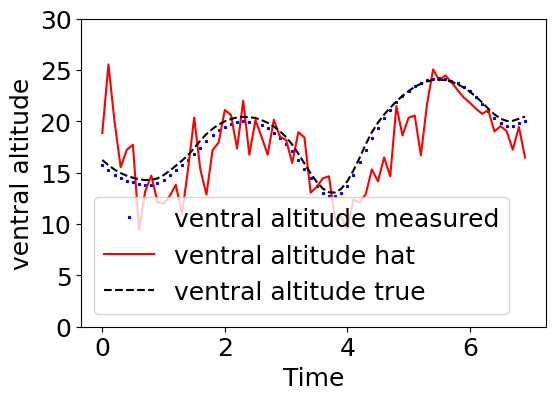

In [67]:
t_sim = np.arange(0, ray_estimate.shape[1]*0.1, 0.1)

ax = plot_tme(t_sim,
         ray_true_compressed_recon[105,:],
         ray_true[105,:],
         ray_estimate[105,:],
         label_var='ventral altitude')

ax.set_ylim(0, 30)

# 7.&nbsp;Exercises

1. **Additional compression:** Apply SVD to compress the time delay-embedded (augmented) input space. This should provide much greater compression than compressing only the instantaneous measurements. Try compressing:
   - Only the optic flow time-history
   - All time-delayed inputs together
   - Compare network performance with different compression levels

2. **Integration with filtering:** Integrate the ANN estimates into an AI-KF (Artificial Intelligence Kalman Filter) framework. Use the compressed ray distance estimates as pseudo-measurements in a filter that estimates the full drone state.

3. **Architecture exploration:** Experiment with different neural network architectures:
   - Try recurrent layers (LSTM/GRU) instead of delay embedding
   - Vary the number and size of hidden layers
   - Test different activation functions and regularization techniques

4. **Robustness analysis:** Test the network's robustness to:
   - Different noise levels than used in training
   - Out-of-distribution terrain profiles
   - Missing or corrupted sensor inputs